In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ast import literal_eval
import pickle as pickle
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools

In [6]:
class RE_Dataset(torch.utils.data.Dataset):
    """ Dataset 구성을 위한 class."""
    def __init__(self, pair_dataset, labels):
        self.pair_dataset = pair_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def inference(model, tokenized_sent, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
    model.eval()
    output_pred = []
    output_prob = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
              input_ids=data['input_ids'].to(device),
              attention_mask=data['attention_mask'].to(device)
              )
            logits = outputs[0]
            prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
            logits = logits.detach().cpu().numpy()
            result = np.argmax(logits, axis=-1)

            output_pred.append(result)
            output_prob.append(prob)

    return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

def preprocessing_dataset(dataset):
    """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entities = []
    subject_entity_types = []
    subject_idx = []

    object_entities = []
    object_entity_types = []
    object_idx = []
    for subject_entity, object_entity in zip(dataset['subject_entity'], dataset['object_entity']):
        subject_entity = literal_eval(subject_entity)
        object_entity = literal_eval(object_entity)

        subject_word = subject_entity['word']
        object_word = object_entity['word']

        subj_type = subject_entity['type']
        obj_type = object_entity['type']

        subject_s_idx = int(subject_entity['start_idx'])
        subject_e_idx = int(subject_entity['end_idx'])

        object_s_idx = int(object_entity['start_idx'])
        object_e_idx = int(object_entity['end_idx'])

        subject_entities.append(subject_word)
        subject_entity_types.append(subj_type)
        subject_idx.append([subject_s_idx, subject_e_idx])

        object_entities.append(object_word)
        object_entity_types.append(obj_type)
        object_idx.append([object_s_idx, object_e_idx])

    out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],
          'subject_entity':subject_entities, 'subject_entity_types': subject_entity_types, 'subject_entity_idx': subject_idx,
          'object_entity':object_entities, 'object_entity_types': object_entity_types, 'object_entity_idx': object_idx,'label':dataset['label'],})

    return out_dataset

def tokenized_dataset(dataset, tokenizer):
    """ tokenizer에 따라 sentence를 tokenizing 합니다."""
    type_to_ko = {"PER":"사람", "ORG":"단체", "POH" : "기타", "LOC" : "장소", "NOH" : "수량", "DAT" : "날짜"}
#     for idx, (e01_idx, e02_idx) in enumerate(zip(dataset['subject_entity_idx'], dataset['object_entity_idx'])):
#         temp_sentence = dataset['sentence'].iloc[idx]
#         temp_sentence = (temp_sentence[:e01_idx[0]] + ' [E1] ' + temp_sentence[e01_idx[0]:e01_idx[1]+1] + ' [/E1] ' 
#         + temp_sentence[e01_idx[1]+1:e02_idx[0]] + ' [E2] ' + temp_sentence[e02_idx[0]:e02_idx[1]+1] + ' [/E2] ' + temp_sentence[e02_idx[1]+1:])
#         dataset['sentence'].iloc[idx] = temp_sentence
        
    # for idx, (e01_idx, e01_type, e02_idx, e02_type) in enumerate(zip(dataset['subject_entity_idx'], dataset['subject_entity_types'], dataset['object_entity_idx'], dataset['object_entity_types'])):
    #     temp_sentence = dataset['sentence'].iloc[idx]
    #     temp_sentence = (temp_sentence[:e01_idx[0]] + f'@ * {type_to_ko[e01_type]} * ' + temp_sentence[e01_idx[0]:e01_idx[1]+1] + ' @ ' 
    #     + temp_sentence[e01_idx[1]+1:e02_idx[0]] + f'+ ^ {type_to_ko[e02_type]} ^ ' + temp_sentence[e02_idx[0]:e02_idx[1]+1] + ' + ' + temp_sentence[e02_idx[1]+1:])
    #     dataset['sentence'].iloc[idx] = temp_sentence
    
    for idx, (e01_idx, e01_type, e02_idx, e02_type) in enumerate(zip(dataset['subject_entity_idx'], dataset['subject_entity_types'], dataset['object_entity_idx'], dataset['object_entity_types'])):
        temp_sentence = dataset['sentence'].iloc[idx]
        temp_sentence = (temp_sentence[:e01_idx[0]] + f' @* ' + temp_sentence[e01_idx[0]:e01_idx[1]+1] + ' @ ' 
        + temp_sentence[e01_idx[1]+1:e02_idx[0]] + f' +^ ' + temp_sentence[e02_idx[0]:e02_idx[1]+1] + ' + ' + temp_sentence[e02_idx[1]+1:])
        dataset['sentence'].iloc[idx] = temp_sentence
    tokenized_sentences = tokenizer(
    list(dataset['sentence']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=256,
    add_special_tokens=True,
    #return_token_type_ids=False, # 문장 id
    )

    return tokenized_sentences

def load_data(dataset_dir, type_):
    """ csv 파일을 경로에 맡게 불러 옵니다. """
    pd_dataset = pd.read_csv(dataset_dir)
    
    if type_ == 'binary':
        pd_dataset.loc[pd_dataset.label != 'no_relation', 'label'] = 'org:top_members/employees'
    elif type_ == 'multi':
        pd_dataset = pd_dataset.loc[pd_dataset.label != 'no_relation']
    dataset = preprocessing_dataset(pd_dataset)

    return dataset

def load_test_dataset(dataset_dir, tokenizer):
    """
    test dataset을 불러온 후,
    tokenizing 합니다.
    """
    test_dataset = load_data(dataset_dir)
    test_label = test_dataset['label'].values #list(map(int,test_dataset['label'].values))

    # tokenizing dataset
    tokenized_test = tokenized_dataset(test_dataset, tokenizer)
    return test_dataset['id'], tokenized_test, test_label

def label_to_num(label):
    num_label = []
    with open('dict_label_to_num.pkl', 'rb') as f:
        dict_label_to_num = pickle.load(f)
        for v in label:
            num_label.append(dict_label_to_num[v])

    return num_label

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(30, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 90)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def make_entity_embedding(token_list):
    entity_embedding = np.zeros(len(token_list))
    sjb_start_idx = 0
    sjb_end_idx = 0
    for idx, t in enumerate(token_list):
        if t == 36 and token_list[idx+1] == 14 and (token_list[idx+2] in [3611, 3971, 5867, 4938, 12395, 9384]):
            sjb_start_idx = idx + 4
            sjb_end_idx = sjb_start_idx + 1
            while token_list[sjb_end_idx] != 36:
                sjb_end_idx += 1

    entity_embedding[sjb_start_idx:sjb_end_idx] = 1

    obj_start_idx = 0
    obj_end_idx = 0
    for idx, t in enumerate(token_list):
        if t == 15 and token_list[idx+1] == 65 and (token_list[idx+2] in [3611, 3971, 5867, 4938, 12395, 9384]):
            obj_start_idx = idx + 4
            obj_end_idx = obj_start_idx + 1
            while token_list[obj_end_idx] != 15:
                obj_end_idx += 1

    entity_embedding[obj_start_idx:obj_end_idx] = 1
    return entity_embedding

In [3]:
# git/klue-level2-nlp-13-1/results/bert_C3F7_AW_CS_Spt_data_binary/checkpoint-500
model_path = '/git/klue-level2-nlp-13-1/best_model/robertaL_ECdata_spt_EM/'
type_ = 'all'
data_path = '../../dataset/train/train.csv'
use_special = True
new_special_token_list = ['[E1]', '[/E1]', '[E2]', '[/E2]']

In [4]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')
#model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')
if use_special:
    special_tokens_dict = {'additional_special_tokens': new_special_token_list}
    num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
    #model.resize_token_embeddings(len(tokenizer))

In [5]:
dataset = load_data(data_path, type_)
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], shuffle=True, random_state=42)

In [7]:
train_label = label_to_num(train_dataset['label'].values)
valid_label = label_to_num(valid_dataset['label'].values)

In [7]:
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_valid = tokenized_dataset(valid_dataset, tokenizer)
#full_dataset = tokenized_dataset(valid_dataset, tokenizer)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
print(train_dataset['sentence'].iloc[0])
print(tokenized_train['input_ids'][0].numpy())
#print(make_entity_embedding(tokenized_train['input_ids'][0].numpy()))
print(tokenizer.convert_ids_to_tokens(tokenized_train['input_ids'][0].numpy()))

 @* 추승우 @ (秋承佑, 1979년 9월 24일 ~)는 전 KBO 리그 한화 이글스의 외야수이자, 현재 KBO 리그 한화 이글스의 작전·주루 및  +^ 외야수 +  수비 코치이다.
[    0    36    14  1672  2164  2137    36    12     3     3     3    16
 11672  2440    29  2429  4056  2210    97    13   793  1537 11114  4469
  5621 28205  2079 22972  2052  2155    16  3738 11114  4469  5621 28205
  2079  6229   100  1564  2162  1116    15    65 22972    15  6061  7102
 28674    18     2     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [57]:
tokenizer.convert_tokens_to_ids(["사람", "단체", "기타", "장소", "수량", "날짜"])

[3611, 3971, 5867, 4938, 12395, 9384]

In [65]:
RE_train_dataset = RE_Dataset(tokenized_train, train_label)
RE_valid_dataset = RE_Dataset(tokenized_valid, valid_label)

In [66]:
pred_answer, output_prob = inference(model, RE_valid_dataset, 'cuda:0')

In [77]:
cm = confusion_matrix(np.array(valid_label)-1, np.array(pred_answer))

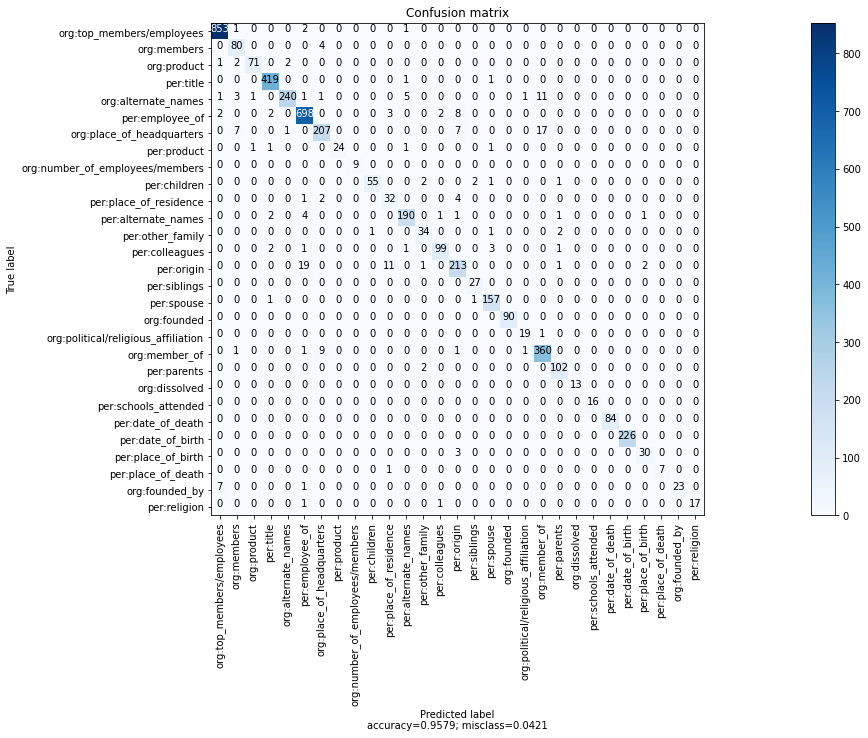

In [82]:
#labels = ['no_relation', 'relation']
labels = [ 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
plot_confusion_matrix(cm, target_names=labels, normalize = False)

In [ ]:
t_list = tokenized_train['input_ids'][0].numpy()
leng = 0
for t in full_dataset['input_ids']:
    tn = t.numpy()
    tn = np.delete(tn, np.where(tn == 0))
    leng += len(tn)
print(leng/len(full_dataset['input_ids']))

In [93]:
a = np.array([1,2,3,4,5])
print(a)

[1 2 3 4 5]


In [96]:
a[2:5] = 1

In [97]:
a

array([1, 2, 1, 1, 1])

In [98]:
a = tokenized_train['input_ids'][0].numpy()

In [99]:
print(a)

[    2 32000  8272    22  2103 32001  1453 32002 27330  2160  2416 32003
  6717  2079 10276  2096  2073  7815  2302  2440    24  2429  3909  2210
  6335 27135 11986  3876  2103  2079  1589  2165  4402 19758  2496  2359
  2062    18     3     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [104]:
np.where(a==32001)[0][0]

5

In [67]:
tokenized_train

{'input_ids': tensor([[    0,    36,    14,  ...,     1,     1,     1],
        [    0,    36,    14,  ...,     1,     1,     1],
        [    0, 10165,  2179,  ...,     1,     1,     1],
        ...,
        [    0,  3935, 11187,  ...,     1,     1,     1],
        [    0, 14153,  2682,  ...,     1,     1,     1],
        [    0,  7388,  2259,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [69]:
tokenized_train['input_ids'][1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
print(list(make_entity_embedding(tokenized_train['input_ids'][0].numpy())))

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [58]:
a = np.array([[1,2,3,4,5], [1,2,3,4,5]])

In [62]:
np.sum(a, axis=0)

array([ 2,  4,  6,  8, 10])

In [84]:
a = torch.tensor([[1.0,1.0,1.0], [1.0,1.0,1.0]])
b = torch.tensor([[2.0,2.0,2.0], [2.0,2.0,2.0]])
c = torch.tensor([[3.0,3.0,3.0], [3.0,3.0,3.0]])

In [82]:
torch.mean(a, axis=0)

tensor([2., 2., 2.])

In [90]:
d = torch.cat([a,b,c], axis=1)

In [87]:
print(a.shape)

torch.Size([2, 3])


In [88]:
print(d.shape)

torch.Size([6, 3])


In [91]:
d

tensor([[1., 1., 1., 2., 2., 2., 3., 3., 3.],
        [1., 1., 1., 2., 2., 2., 3., 3., 3.]])

In [94]:
tokenizer.convert_tokens_to_ids(['사람',' 단체', '기타', '장소', '수량', '날짜'])

[3611, 3, 5867, 4938, 12395, 9384]

In [95]:
1 in [1, 2, 3, 4]

True

In [96]:
import torch.nn as nn

In [120]:
embedding = nn.Embedding(30, 5)

In [121]:
input = torch.LongTensor([[1,0],[0,1]])

In [122]:
embedding(input)

tensor([[[-0.3887, -0.4937, -0.6906,  0.7804,  0.3899],
         [-0.9645,  0.8605,  1.8318, -1.0429, -1.1527]],

        [[-0.9645,  0.8605,  1.8318, -1.0429, -1.1527],
         [-0.3887, -0.4937, -0.6906,  0.7804,  0.3899]]],
       grad_fn=<EmbeddingBackward>)

In [123]:
embedding(input)

tensor([[[-0.3887, -0.4937, -0.6906,  0.7804,  0.3899],
         [-0.9645,  0.8605,  1.8318, -1.0429, -1.1527]],

        [[-0.9645,  0.8605,  1.8318, -1.0429, -1.1527],
         [-0.3887, -0.4937, -0.6906,  0.7804,  0.3899]]],
       grad_fn=<EmbeddingBackward>)

In [17]:
def get_entity_idxes(tokenizer, token_list, add_special_token):
    entity_embedding = np.zeros(len(token_list))
    if add_special_token == 'special':
        entity_embedding[np.where(token_list==32000)[0][0]+1:np.where(token_list==32001)[0][0]] = 1
        entity_embedding[np.where(token_list==32002)[0][0]+1:np.where(token_list==32003)[0][0]] = 1
        return entity_embedding
    elif add_special_token == 'punct_type':
        # @: 36, *: 14, +: 15, ^: 65, 사람: 3611, 단체: 3971, 기타: 5867, 장소: 4938, 수량: 12395, 날짜: 9384
        subj_1 = tokenizer.convert_tokens_to_ids('@')
        subj_2 = tokenizer.convert_tokens_to_ids('*')
        obj_1 = tokenizer.convert_tokens_to_ids('+')
        obj_2 = tokenizer.convert_tokens_to_ids('^')
        names = tokenizer.convert_tokens_to_ids(['사람','단체', '기타', '장소', '수량', '날짜'])

        sjb_start_idx = 0
        sjb_end_idx = 0
        for idx, t in enumerate(token_list):
            if t == subj_1 and token_list[idx+1] == subj_2 and (token_list[idx+2] in names):
                sjb_start_idx = idx + 4
                sjb_end_idx = sjb_start_idx + 1
                while token_list[sjb_end_idx] != subj_1:
                    sjb_end_idx += 1
                break

        entity_embedding[sjb_start_idx:sjb_end_idx] = 1

        obj_start_idx = 0
        obj_end_idx = 0
        for idx, t in enumerate(token_list):
            if t == obj_1 and token_list[idx+1] == obj_2 and (token_list[idx+2] in names):
                obj_start_idx = idx + 4
                obj_end_idx = obj_start_idx + 1
                while token_list[obj_end_idx] != obj_1:
                    obj_end_idx += 1
                break
        entity_embedding[obj_start_idx:obj_end_idx] = 2
        return entity_embedding, sjb_start_idx, sjb_end_idx, obj_start_idx, obj_end_idx

    elif add_special_token == 'punct':
        subj_1 = tokenizer.convert_tokens_to_ids('@')
        subj_2 = tokenizer.convert_tokens_to_ids('*')
        obj_1 = tokenizer.convert_tokens_to_ids('+')
        obj_2 = tokenizer.convert_tokens_to_ids('^')

        sjb_start_idx = 0
        sjb_end_idx = 0
        for idx, t in enumerate(token_list):
            if t == subj_1 and token_list[idx+1] == subj_2:
                sjb_start_idx = idx + 2
                sjb_end_idx = sjb_start_idx + 1
                while token_list[sjb_end_idx] != subj_1:
                    sjb_end_idx += 1
                break

        entity_embedding[sjb_start_idx:sjb_end_idx] = 1

        obj_start_idx = 0
        obj_end_idx = 0
        for idx, t in enumerate(token_list):
            if t == obj_1 and token_list[idx+1] == obj_2:
                obj_start_idx = idx + 2
                obj_end_idx = obj_start_idx + 1
                while token_list[obj_end_idx] != obj_1:
                    obj_end_idx += 1
                break

        return entity_embedding, sjb_start_idx, sjb_end_idx, obj_start_idx, obj_end_idx

def insert_entity_idx_tokenized_dataset(tokenizer, dataset, add_special_token):
    if add_special_token == 'special':
        entity_embeddings = [get_entity_idxes(tokenizer, ids, config) for ids in dataset['input_ids'].numpy()]
        dataset['Entity_type_embedding'] = torch.tensor(entity_embeddings).to(torch.int64)
    elif add_special_token == 'punct' or config.add_special_token == 'punct_type':
        entity_embeddings = []
        entity_idxes = []
        for ids in dataset['input_ids'].numpy():
            entity_embedding, sjb_start_idx, sjb_end_idx, obj_start_idx, obj_end_idx = get_entity_idxes(tokenizer, ids, add_special_token)
            entity_embeddings.append(entity_embedding)
            entity_idxes.append([sjb_start_idx, sjb_end_idx, obj_start_idx, obj_end_idx])
        dataset['Entity_type_embedding'] = torch.tensor(entity_embeddings).to(torch.int64)
        dataset['Entity_idxes'] = torch.tensor(entity_idxes).to(torch.int64)

In [18]:
insert_entity_idx_tokenized_dataset(tokenizer, tokenized_train, 'punct')

In [20]:
tokenized_train[''][0]

Encoding(num_tokens=256, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [21]:
print(train_dataset['sentence'].iloc[0])
print(tokenized_train['input_ids'][0].numpy())
#print(make_entity_embedding(tokenized_train['input_ids'][0].numpy()))
print(tokenizer.convert_ids_to_tokens(tokenized_train['input_ids'][0].numpy()))

 @* 추승우 @ (秋承佑, 1979년 9월 24일 ~)는 전 KBO 리그 한화 이글스의 외야수이자, 현재 KBO 리그 한화 이글스의 작전·주루 및  +^ 외야수 +  수비 코치이다.
[    0    36    14  1672  2164  2137    36    12     3     3     3    16
 11672  2440    29  2429  4056  2210    97    13   793  1537 11114  4469
  5621 28205  2079 22972  2052  2155    16  3738 11114  4469  5621 28205
  2079  6229   100  1564  2162  1116    15    65 22972    15  6061  7102
 28674    18     2     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   